In [24]:
import numpy as np
import pandas as pd
import scipy.stats as stats
import seaborn as sns

import torch
import torch.nn as nn
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib import font_manager, rc

# from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from tqdm import tqdm

### 데이터 불러오기

In [2]:
train_sp = pd.read_csv('./data_4dist/data_tr_4dist.csv')
test_sp = pd.read_csv('./data_4dist/data_ts_4dist.csv')

train_sp.rename(columns={'4단지배수지 공업 유출유량 적산차':'4dist'}, inplace=True)
test_sp.rename(columns={'4단지배수지 공업 유출유량 적산차':'4dist'}, inplace=True)

print(type(train_sp),'\n', len(train_sp))

<class 'pandas.core.frame.DataFrame'> 
 35063


In [3]:
train_sp

,datetime,4dist
0,2017-01-01 01:00:00,525.0
1,2017-01-01 02:00:00,542.0
2,2017-01-01 03:00:00,392.0
3,2017-01-01 04:00:00,379.0
4,2017-01-01 05:00:00,353.0
...,...,...
35058,2020-12-31 19:00:00,626.0
35059,2020-12-31 20:00:00,294.0
35060,2020-12-31 21:00:00,234.0
35061,2020-12-31 22:00:00,704.0


#### train 세트 결측값 유무 확인

In [4]:
print(train_sp.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35063 entries, 0 to 35062
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   datetime  35063 non-null  object 
 1   4dist     35051 non-null  float64
dtypes: float64(1), object(1)
memory usage: 548.0+ KB
None


##### 결측값을 바로 뒤에 데이터로 채움

In [5]:
train_sp = train_sp.ffill()

In [6]:
print(train_sp.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35063 entries, 0 to 35062
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   datetime  35063 non-null  object 
 1   4dist     35063 non-null  float64
dtypes: float64(1), object(1)
memory usage: 548.0+ KB
None


In [7]:
print(train_sp['4dist'].describe())

count    3.506300e+04
mean     4.811422e+02
std      1.176769e+05
min     -1.493708e+07
25%      3.600000e+02
50%      4.580000e+02
75%      5.640000e+02
max      1.237570e+07
Name: 4dist, dtype: float64


### 데이터 시각화

#### 선 그래프

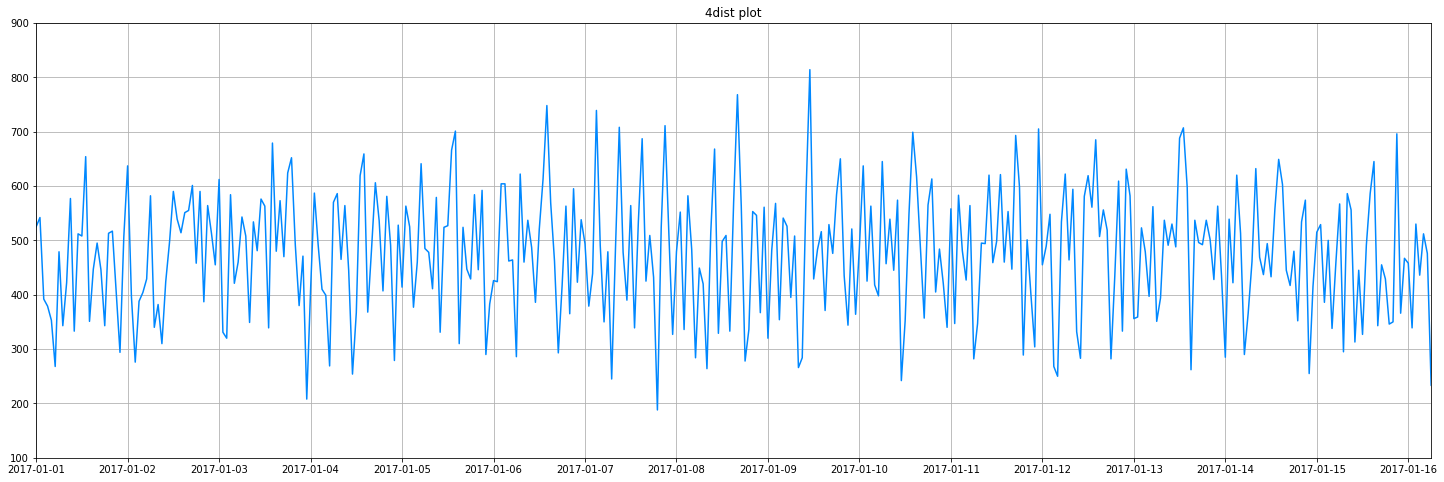

In [8]:
plt.rcParams['figure.figsize'] = (25.0, 8.0)\

x = np.arange(0, len(train_sp), 24)
date = train_sp['datetime'].str.slice(stop=10)
date_x = list(range(len(x)))
for i in range(len(x)):
    j = i * 24
    date_x[i]=date[j]

plt.title("4dist plot")
plt.ylim(100, 900)
plt.xticks(x, labels=date_x)
plt.xlim(0, 366)
plt.grid(True)
plt.plot(train_sp['4dist'], color='#0088ff')

plt.show()

#### 정규/가우시안 분포 및 히스토그램 출력

In [9]:
cv_mean = np.mean(train_sp["4dist"])
cv_std = np.std(train_sp["4dist"])

print('평균:{:.4f} / 표준편차:{:.4f}'.format(cv_mean, cv_std))

평균:481.1422 / 표준편차:117675.2235


In [10]:
import scipy.stats as stats

cv_pdf = stats.norm.pdf(train_sp["4dist"].sort_values(), cv_mean, cv_std)
print('확률밀도함수:{}'.format(cv_pdf))

확률밀도함수:[0.00000000e+00 0.00000000e+00 3.39016943e-06 ... 3.38865207e-06
 0.00000000e+00 0.00000000e+00]


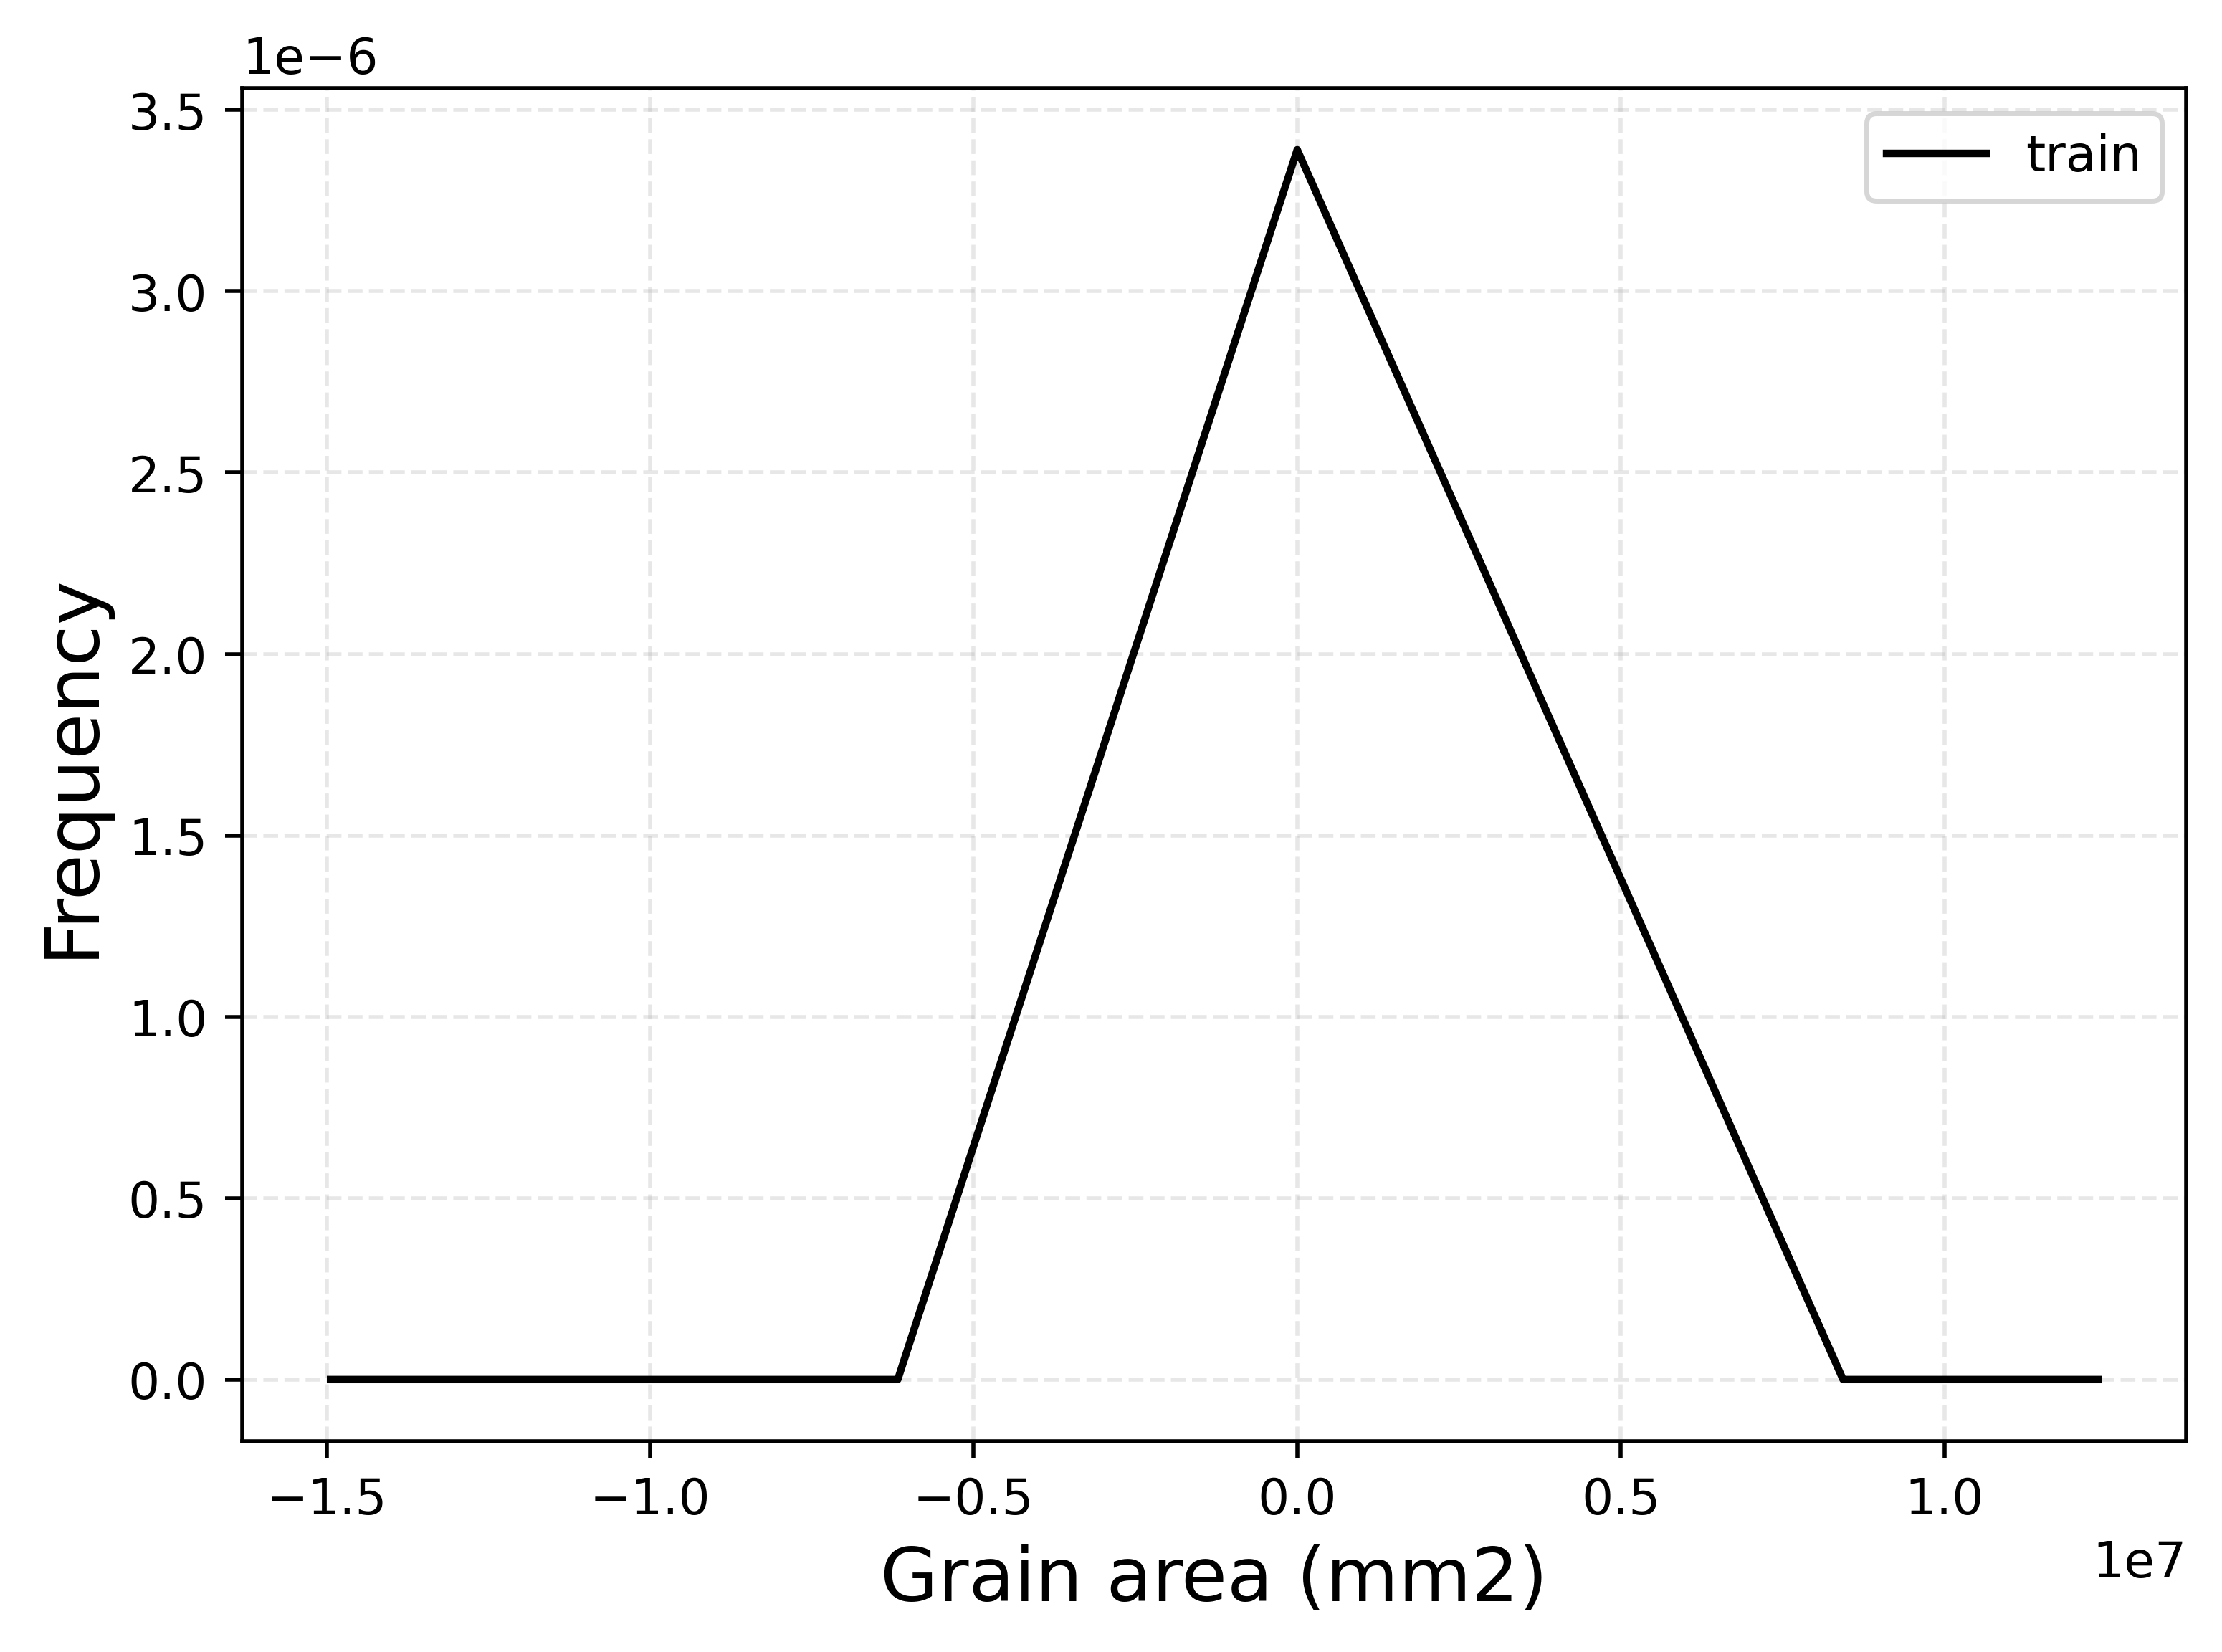

In [13]:
plt.plot(train_sp["4dist"].sort_values(), cv_pdf, color="Black", label="train")
# sns.histplot(train_sp["4dist"], color="Orange",stat = "probability",alpha=0.5)
# plt.hist(train_sp["4dist"], color="Orange", bins=100)
# sns.distplot(train_sp["4dist"], color="Orange")

# plt.xlim([0,30])
# plt.ylim([1e-7, 1e-32])
plt.legend()
plt.xlabel("Grain area (mm2)", size=15)
plt.ylabel("Frequency", size=15)
plt.grid(True, alpha=0.3, linestyle="--")
plt.rcParams["figure.figsize"] = [7,5]  # 가로, 세로 인치 조정
plt.rcParams["figure.dpi"] = 500   # 해상도 조정
plt.show()

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='4dist', ylabel='Density'>

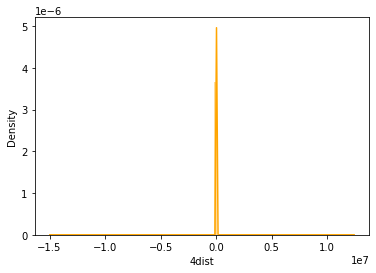

In [70]:
sns.distplot(train_sp["4dist"], color="Orange", bins=100)

<AxesSubplot:ylabel='Frequency'>

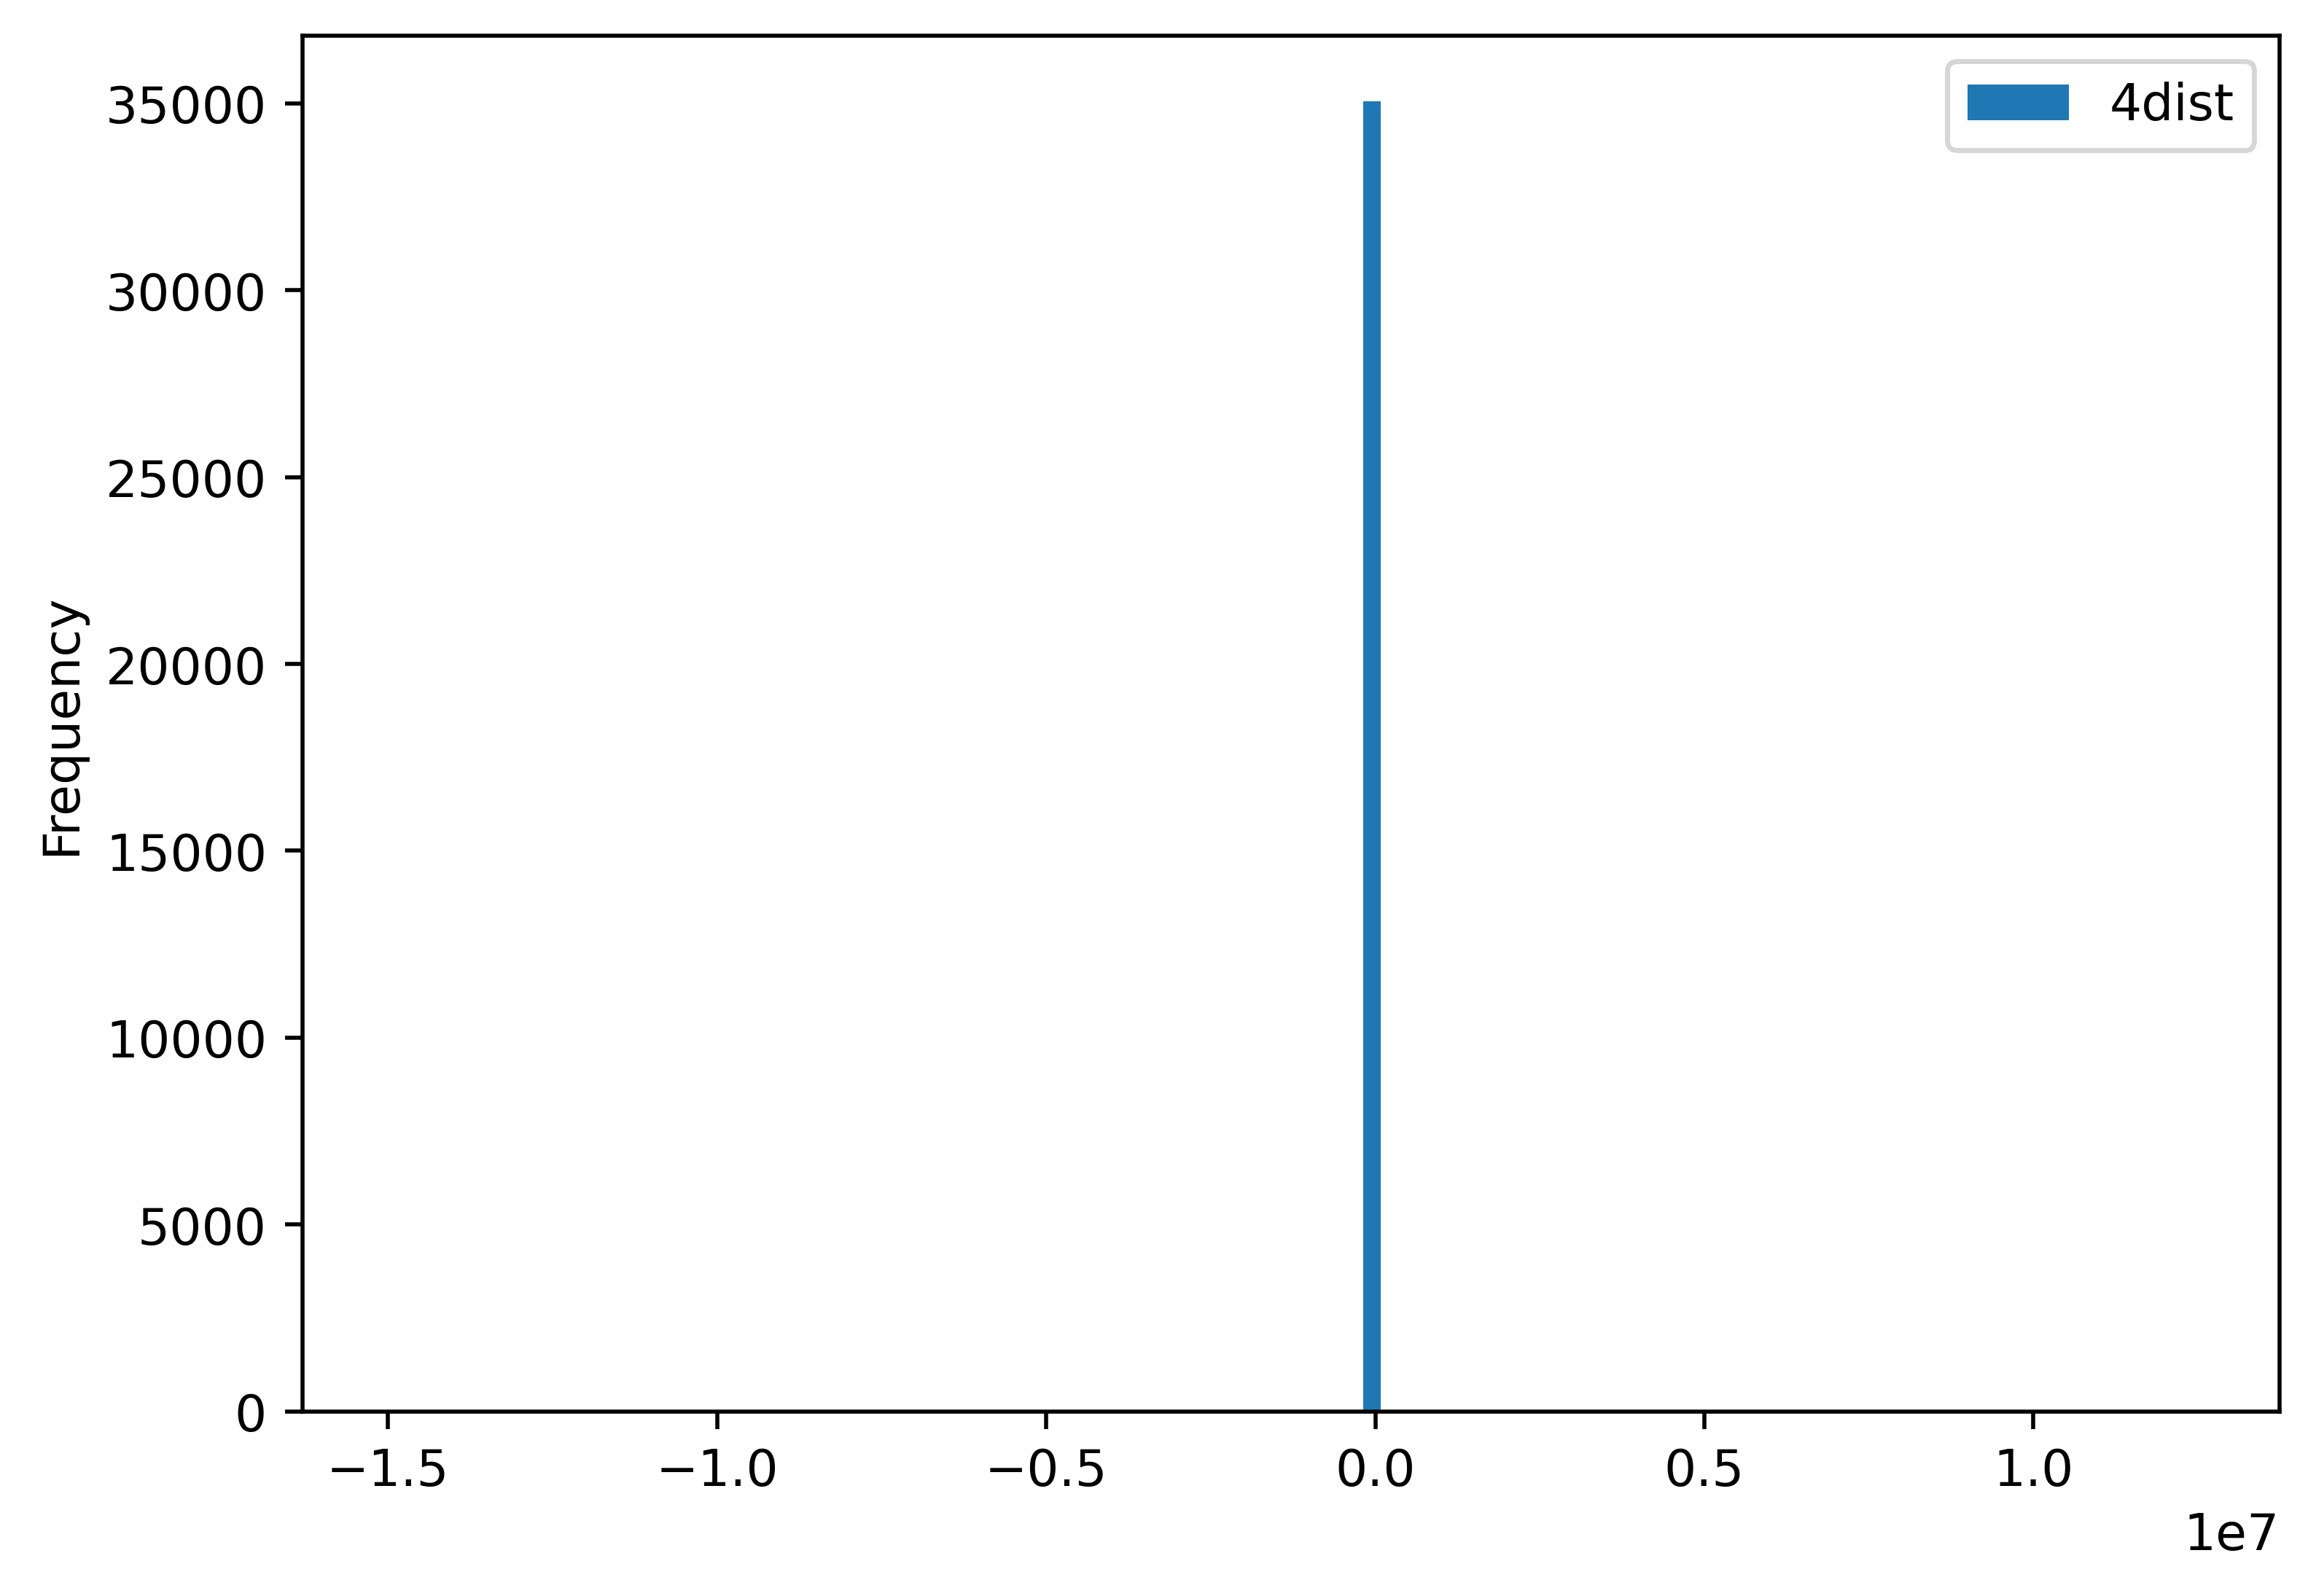

In [16]:
train_sp.plot(kind="hist", y="4dist", bins=100)

##### error

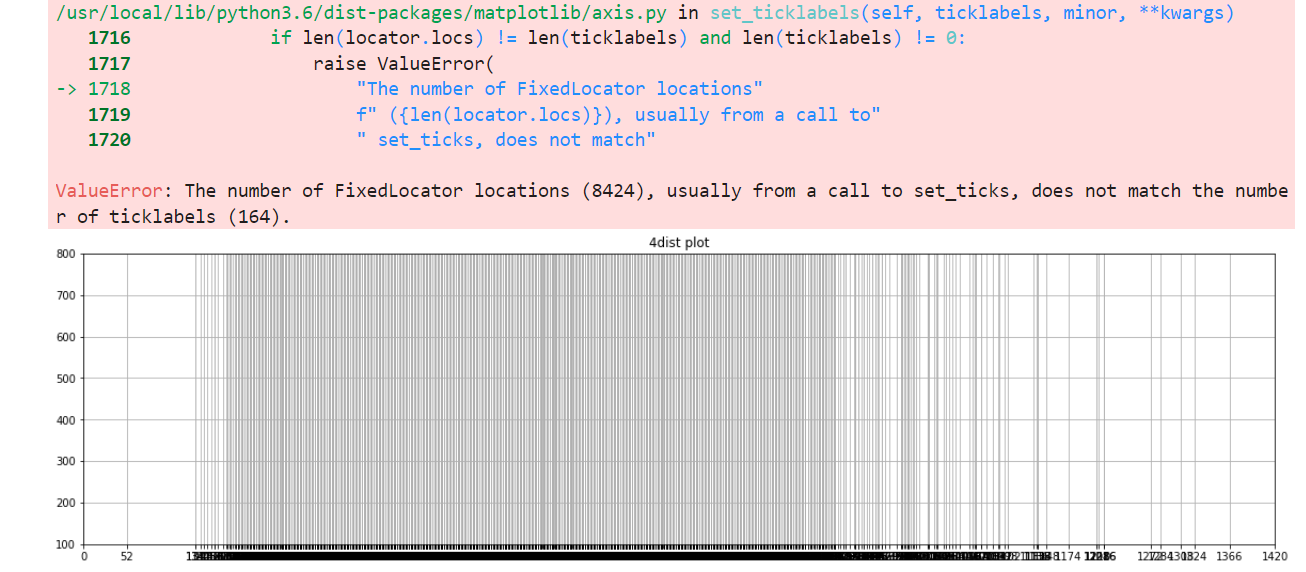

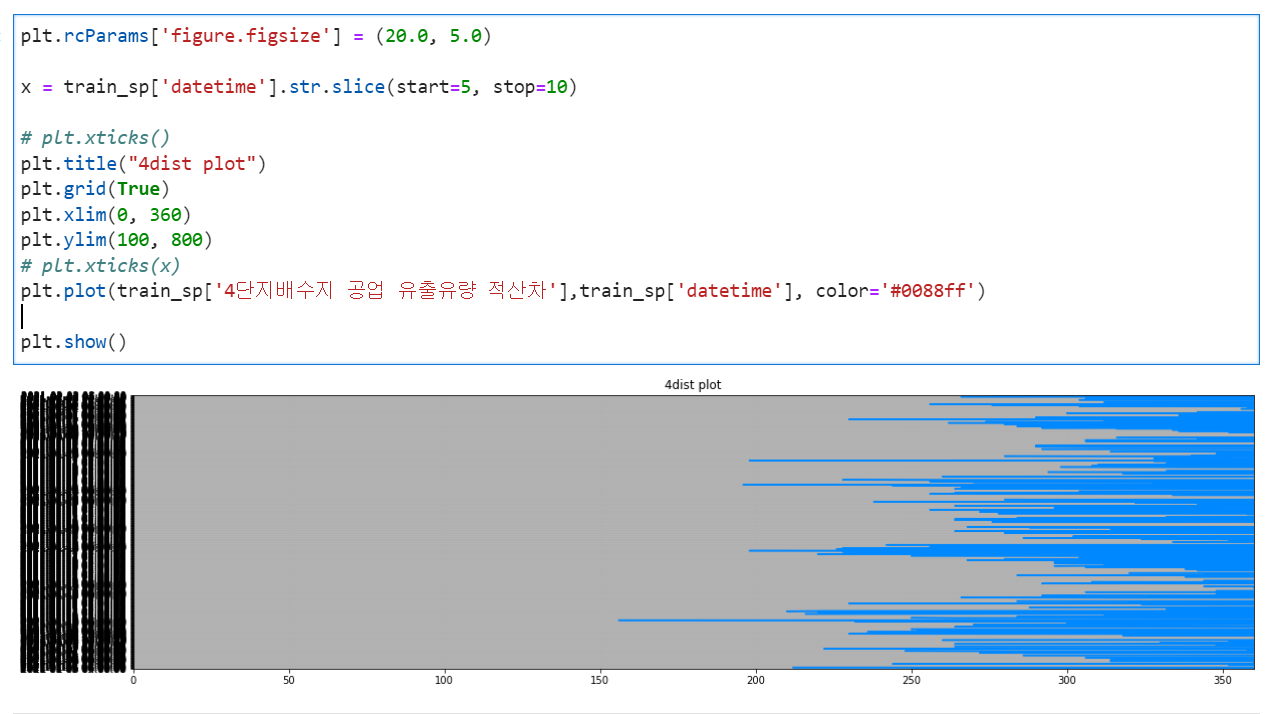

### 데이터 분할

In [20]:
test_size = round(len(train_sp) * 0.3)
train_set = train_sp[: -test_size]
val_set = train_sp[-test_size:]

In [21]:
train_set

,datetime,4dist
0,2017-01-01 01:00:00,525.0
1,2017-01-01 02:00:00,542.0
2,2017-01-01 03:00:00,392.0
3,2017-01-01 04:00:00,379.0
4,2017-01-01 05:00:00,353.0
...,...,...
24539,2019-10-20 12:00:00,344.0
24540,2019-10-20 13:00:00,376.0
24541,2019-10-20 14:00:00,304.0
24542,2019-10-20 15:00:00,366.0


In [22]:
val_set

,datetime,4dist
24544,2019-10-20 17:00:00,382.0
24545,2019-10-20 18:00:00,214.0
24546,2019-10-20 19:00:00,458.0
24547,2019-10-20 20:00:00,256.0
24548,2019-10-20 21:00:00,376.0
...,...,...
35058,2020-12-31 19:00:00,626.0
35059,2020-12-31 20:00:00,294.0
35060,2020-12-31 21:00:00,234.0
35061,2020-12-31 22:00:00,704.0


### 데이터 스케일링

In [25]:
train_set['4dist_scale'] = train_set['4dist']

# scaler = MinMaxScaler()
scaler = StandardScaler()
train_set[['4dist_scale']] = scaler.fit_transform(train_set[['4dist_scale']])

train_set

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:1734: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the

,datetime,4dist,4dist_scale
0,2017-01-01 01:00:00,525.0,0.000100
1,2017-01-01 02:00:00,542.0,0.000221
2,2017-01-01 03:00:00,392.0,-0.000846
3,2017-01-01 04:00:00,379.0,-0.000938
4,2017-01-01 05:00:00,353.0,-0.001123
...,...,...,...
24539,2019-10-20 12:00:00,344.0,-0.001187
24540,2019-10-20 13:00:00,376.0,-0.000959
24541,2019-10-20 14:00:00,304.0,-0.001471
24542,2019-10-20 15:00:00,366.0,-0.001030


In [26]:
train_np = train_set[['4dist_scale']]
train_ts = torch.from_numpy(train_np.values).float()

print(train_ts, '\n', len(train_ts), 'low \n',  type(train_ts))

tensor([[ 0.0001],
        [ 0.0002],
        [-0.0008],
        ...,
        [-0.0015],
        [-0.0010],
        [-0.0009]]) 
 24544 low 
 <class 'torch.Tensor'>


In [27]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(f'{device} is available')

cuda:0 is available


### input 설정

In [28]:
def input_data(seq, ws):
    out = []
    L = len(seq)
    
    for i in range(L-ws):
        window = seq[i:i+ws] # 0 ~ 366 -> 367
        label = seq[i+ws:i+ws+1] # 366:367
        out.append((window,label))
    
    return out

In [29]:
window_size = 366
train_data = input_data(train_ts, window_size)
len(train_data)

24178

In [30]:
train_ts[:10].shape

torch.Size([10, 1])

In [32]:
train_data[0][0].shape

torch.Size([366, 1])

In [33]:
# 배치로 나눠주기
trainloader = torch.utils.data.DataLoader(train_data, batch_size=16, shuffle=False, num_workers=2)

In [34]:
print(6228/16)
len(trainloader)

389.25


1512

### 모델

#### 모델 정의

In [35]:
class LSTM(nn.Module):
    
    def __init__(self, input_size = 1, hidden_size = 366, seq = 366, out_size = 1, batch_size= 1): # , batch_size = 1
        super().__init__()
        self.hidden_size = hidden_size
        self.input_size = input_size
        # self.batch_size = batch_size
        self.lstm = nn.LSTM(input_size, hidden_size)
        self.linear = nn.Linear(hidden_size, out_size)
        self.hidden = (torch.zeros(1, seq, hidden_size),torch.zeros(1, seq, hidden_size))
        
        self.reset_hidden_state()
    
    def reset_hidden_state(self):
        self.hidden = (torch.zeros(self.hidden[0].shape).to(device),
                       torch.zeros(self.hidden[1].shape).to(device))
    
    def forward(self,seq):
        lstm_out, self.hidden = self.lstm(seq , self.hidden)
        pred = self.linear(lstm_out[:,-1])
        return pred

#### loss(RMSE) 정의

In [36]:
class RMSELoss(nn.Module):
    def __init__(self):
        super().__init__()
        self.mse = nn.MSELoss()
        
    def forward(self,yhat,y):
        return torch.sqrt(self.mse(yhat,y))


#### 모델 인스턴스화

In [37]:
torch.manual_seed(42)
model = LSTM(batch_size = 16).to(device)
criterion = RMSELoss()     
# criterion = nn.MSELoss()
# criterion = nn.L1Loss()  #MAE https://pytorch.org/docs/stable/generated/torch.nn.L1Loss.html#torch.nn.L1Loss
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)
# optimizer = torch.optim.ADAM(model.parameters(), lr=0.01)

In [38]:
# batch size,  seq, data size
#         1  ,  366,    1

# 예측값 : 337번째 (seq + )
model

LSTM(
  (lstm): LSTM(1, 366)
  (linear): Linear(in_features=366, out_features=1, bias=True)
)

### 모델 학습

##### data set

In [86]:
epochs = 10
future = 366

loss_list = [0]
pred_list = [0]
train_list = [0]

global a, b

for i in range(epochs):
    
    progress = tqdm(trainloader)
    for seq, y_train in progress:
        
        optimizer.zero_grad()
        
        model.reset_hidden_state()
        y_pred = model(seq.to(device))
        
        a = y_train
        b = y_pred
        break
        
        loss = criterion(y_pred, y_train.to(device))
        loss.backward()
        optimizer.step()
        
        loss_list.append(loss.cpu())
        pred_list.append(y_pred.cpu())
        train_list.append(y_train.cpu())
        
        progress.set_postfix_str(f"Epoch {i} Loss: {loss.item():.7f}")
    # print(f"Epoch {i} Loss: {loss.item():.7f}")
    
    
    # preds = sample_ts[-window_size:].tolist()
    
#     for f in range(future):
#         seq = torch.FloatTensor(preds[-window_size:])
#         with torch.no_grad():
#             model.hidden = (torch.zeros(1,1,model.hidden_size),
#                            torch.zeros(1,1,model.hidden_size))
#             preds.append(model(seq).item())
        
#     loss = criterion(torch.tensor(preds[-window_size:]), y[760:])
#     print(f"Performance on test range: {loss}")
    
#     plt.figure(figsize=(12,4))
#     plt.xlim(6120,6228)
#     plt.grid(True)
#     plt.plot(y.numpy(),color='#8000ff')
#     plt.plot(range(760,800),preds[window_size:],color='#02cccc')
#     plt.show()
print('training Finish')

  0%|          | 0/1512 [00:00<?, ?it/s]

training Finish


In [40]:
pred_list.pop(0)
loss_list.pop(0)

0

In [41]:
len(pred_list)

15120

In [42]:
pred_list[0][2][0]

tensor(-0.0382, grad_fn=<SelectBackward0>)

In [43]:
torch.save(model, 'model_1212.pt')
torch.save(model.state_dict(), 'model1_stateDict_1212.pt')

### test

In [44]:
test_sp

,datetime,4dist
0,2021-01-01 00:00:00,366.0
1,2021-01-01 01:00:00,486.0
2,2021-01-01 02:00:00,364.0
3,2021-01-01 03:00:00,356.0
4,2021-01-01 04:00:00,500.0
...,...,...
8419,2021-12-17 19:00:00,690.0
8420,2021-12-17 20:00:00,510.0
8421,2021-12-17 21:00:00,432.0
8422,2021-12-17 22:00:00,564.0


#### test 세트 데이터 결측값(null) 확인

In [45]:
test_sp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8424 entries, 0 to 8423
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   datetime  8424 non-null   object 
 1   4dist     8424 non-null   float64
dtypes: float64(1), object(1)
memory usage: 131.8+ KB


#### test 세트 값을 0~1사이 값으로 변환

In [46]:
test_sp['4dist_scale'] = test_sp['4dist']

test_sp[['4dist_scale']] = scaler.fit_transform(test_sp[['4dist_scale']])

test_sp

,datetime,4dist,4dist_scale
0,2021-01-01 00:00:00,366.0,-0.783769
1,2021-01-01 01:00:00,486.0,-0.019708
2,2021-01-01 02:00:00,364.0,-0.796503
3,2021-01-01 03:00:00,356.0,-0.847440
4,2021-01-01 04:00:00,500.0,0.069432
...,...,...,...
8419,2021-12-17 19:00:00,690.0,1.279194
8420,2021-12-17 20:00:00,510.0,0.133104
8421,2021-12-17 21:00:00,432.0,-0.363536
8422,2021-12-17 22:00:00,564.0,0.476931


In [47]:
test_np = test_sp[['4dist_scale']]
test_ts = torch.from_numpy(test_np.values).float()

print(test_ts, '\n', len(test_ts), 'low \n',  type(test_ts), test_ts.shape)

tensor([[-0.7838],
        [-0.0197],
        [-0.7965],
        ...,
        [-0.3635],
        [ 0.4769],
        [ 1.3429]]) 
 8424 low 
 <class 'torch.Tensor'> torch.Size([8424, 1])


#### test 세트 input 설정

In [48]:
window_size = 366

def input_data(seq,ws):
    out = []
    L = len(seq)
    for i in range(L-ws):
        window = seq[i:i+ws]
        label = seq[i+ws:i+ws+1]
        out.append((window,label))
    return out


test_data = input_data(test_ts, window_size)

len(test_data)

8058

#### test세트 배치 사이즈

In [49]:
testloader = torch.utils.data.DataLoader(test_data, batch_size=1, shuffle=False, num_workers=2)

#### 모델 로드

In [50]:
# scaler:minMaxScaler(), loss:MSE
model_1 = torch.load('./model1.pt')
model_1.load_state_dict(torch.load('model1_stateDict.pt'))

<All keys matched successfully>

In [54]:
# scaler:StandardScaler(), loss:RMSE
model_2 = torch.load('./model_1212.pt')
model_2.load_state_dict(torch.load('model1_stateDict_1212.pt'))

<All keys matched successfully>

In [55]:
output = [0]

with torch.no_grad():
    for seq, y_train in tqdm(testloader):
        outputs = model_1(seq.cuda())
        
        outputs = outputs.cpu()
        
        output.append(outputs[0][0])

100%|██████████| 8058/8058 [00:11<00:00, 731.56it/s]


##### 오류 목록  

---
TypeError: Caught TypeError in DataLoader worker process 0.
Original Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/_utils/worker.py", line 287, in _worker_loop
    data = fetcher.fetch(index)
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/_utils/fetch.py", line 52, in fetch
    return self.collate_fn(data)
    return [default_collate(samples) for samples in transposed]
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/_utils/collate.py", line 84, in <listcomp>
    return [default_collate(samples) for samples in transposed]
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/_utils/collate.py", line 86, in default_collate
    raise TypeError(default_collate_err_msg_format.format(elem_type))
TypeError: default_collate: batch must contain tensors, numpy arrays, numbers, dicts or lists; found <class 'pandas.core.frame.DataFrame'>
  :num_workers를 0으로 바꾸니 해결
    
     
   2.
TypeError: default_collate: batch must contain tensors, numpy arrays, numbers, dicts or lists; found <class 'pandas.core.frame.DataFrame'>  
    test세트가 dataframe인 채로 들어가서 난 오류였음

##### 값 확인

In [56]:
output[0]

0

In [57]:
output.pop(0)

0

In [58]:
output[0:10]

[tensor(0.5455),
 tensor(0.5462),
 tensor(0.5491),
 tensor(0.5508),
 tensor(0.5518),
 tensor(0.5537),
 tensor(0.5539),
 tensor(0.5514),
 tensor(0.5516),
 tensor(0.5534)]

In [59]:
len(output)

8058

In [60]:
out_ts = torch.stack(output, dim=0)

In [61]:
for i in range(len(output)):
    num = output[i]
    output[i] = num.numpy()

In [62]:
output[0]

array(0.54547197, dtype=float32)

In [63]:
test_df = pd.DataFrame(output)

test_df.head()

,0
0,0.545472
1,0.546233
2,0.549124
3,0.550768
4,0.551835


In [64]:
test_df = scaler.inverse_transform(test_df)
test_df

array([[574.7648 ],
       [574.8844 ],
       [575.33844],
       ...,
       [574.7274 ],
       [575.00916],
       [575.0595 ]], dtype=float32)

In [65]:
test_sp['test'] = test_sp['4dist_scale']

test_sp[['test']] = scaler.inverse_transform(test_sp[['test']])
test_sp

,datetime,4dist,4dist_scale,test
0,2021-01-01 00:00:00,366.0,-0.783769,366.0
1,2021-01-01 01:00:00,486.0,-0.019708,486.0
2,2021-01-01 02:00:00,364.0,-0.796503,364.0
3,2021-01-01 03:00:00,356.0,-0.847440,356.0
4,2021-01-01 04:00:00,500.0,0.069432,500.0
...,...,...,...,...
8419,2021-12-17 19:00:00,690.0,1.279194,690.0
8420,2021-12-17 20:00:00,510.0,0.133104,510.0
8421,2021-12-17 21:00:00,432.0,-0.363536,432.0
8422,2021-12-17 22:00:00,564.0,0.476931,564.0


In [ ]:
a = [1,2,3,4,5]
a[2:]

[3, 4, 5]

In [106]:
test_print = test_sp[366:]
test_print = test_print.reset_index()

In [107]:
print(len(test_print), '\n', len(test_df))
print(test_print[:10])

8058 
 8058
   index             datetime  4dist  4dist_scale   test
0    366  2021-01-16 06:00:00  492.0     0.018495  492.0
1    367  2021-01-16 07:00:00  312.0    -1.127596  312.0
2    368  2021-01-16 08:00:00  416.0    -0.465410  416.0
3    369  2021-01-16 09:00:00  392.0    -0.618222  392.0
4    370  2021-01-16 10:00:00  296.0    -1.229471  296.0
5    371  2021-01-16 11:00:00  422.0    -0.427207  422.0
6    372  2021-01-16 12:00:00  634.0     0.922633  634.0
7    373  2021-01-16 13:00:00  356.0    -0.847440  356.0
8    374  2021-01-16 14:00:00  296.0    -1.229471  296.0
9    375  2021-01-16 15:00:00  300.0    -1.204002  300.0


#### test세트 예측값과 데이터 값 시각화 및 비교

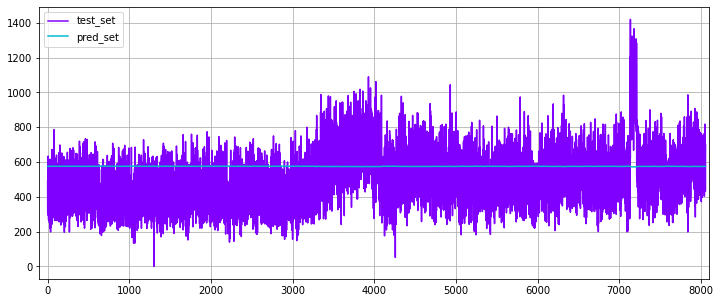

In [77]:
plt.figure(figsize=(12,5))
plt.grid(True)

plt.xlim(-100, 8100)
plt.plot(test_print['4dist'],color='#8000ff')
plt.plot(test_df, color='#02bbcc')

plt.legend(['test_set', 'pred_set'])
plt.show()

In [299]:
test_dataf.shape

(27684,)

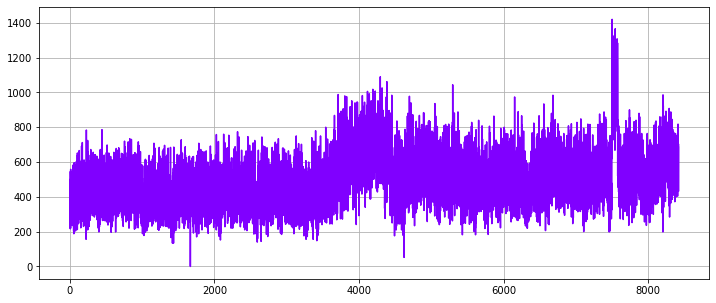

In [71]:
plt.figure(figsize=(12,5))
plt.grid(True)

plt.plot(test_sp['4dist'],color='#8000ff')

plt.show()

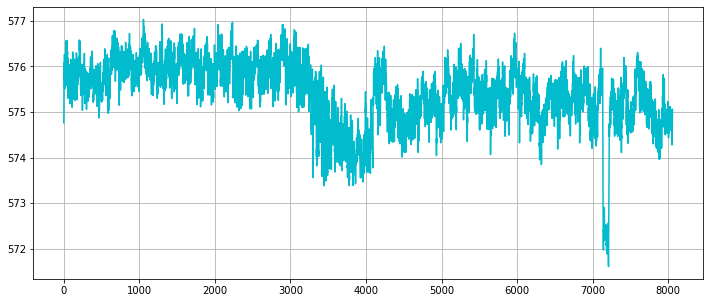

In [72]:
plt.figure(figsize=(12,5))
plt.grid(True)

plt.plot(test_df, color='#02bbcc')

plt.show()

In [ ]:
for param_tensor in model.state_dict():
    print(param_tensor, "\t", model.state_dict()[param_tensor].size())


lstm.weight_ih_l0 	 torch.Size([1464, 1])
lstm.weight_hh_l0 	 torch.Size([1464, 366])
lstm.bias_ih_l0 	 torch.Size([1464])
lstm.bias_hh_l0 	 torch.Size([1464])
linear.weight 	 torch.Size([366, 366])
linear.bias 	 torch.Size([366])


In [ ]:
for param_tensor in testmodel.state_dict():
    print(param_tensor, "\t", testmodel.state_dict()[param_tensor].size())


lstm.weight_ih_l0 	 torch.Size([1464, 1])
lstm.weight_hh_l0 	 torch.Size([1464, 366])
lstm.bias_ih_l0 	 torch.Size([1464])
lstm.bias_hh_l0 	 torch.Size([1464])
linear.weight 	 torch.Size([366, 366])
linear.bias 	 torch.Size([366])
